# Alethea MLE Take Home Assignment

Congratulations on moving to this step of the interview process! This assignment is meant to be a practical assessment of coding that you may expect to do at Alethea. We understand that take home assignments require work beyond your other current responsibilities, and we appreciate you taking the time and effort to answer the questions here.

We ask that you use Python for the assignment, as that is one of the primary programming language we use. You may use any packages that you would like to answer the questions.

## Data

The data that you will be working with is a sample of posts about COVID-19 from December 2023. There are two datasets, `posts` and `accounts`, provided as TSVs and containing the following fields.


### Posts
|    Field   |   Type   |                               Description                              |
|------------|----------|------------------------------------------------------------------------|
| id         | str      | The unique identifier of the post                                      |
| created_at | datetime | The time at which the post was made                                    |
| author_id  | str      | The ID of the account that made the post                               |
| is_repost  | bool     | Whether the post is a repost                                           |
| text       | str      | The text of the post                                                   |
| hashtags   | str      | The unique hashtags present in the post, each separated by a pipe `\|` |

### Accounts

| Field       | Type     | Description                                                          |
|-------------|----------|----------------------------------------------------------------------|
| id          | str      | The unique identifier of the account                                 |
| created_at  | datetime | The time at which the account was made                               |
| screen_name | str      | The screen name of the account, also known as its handle or username |

## Loading Data

Please run the following `wget` commands to download the data into your environment. Then, run the Python cells to structure the data in the format that
we will use for this assignment.

In [ ]:
!wget https://alethea-take-home.s3.amazonaws.com/posts.tsv
!wget https://alethea-take-home.s3.amazonaws.com/accounts.tsv

In [ ]:
#!pip install polars

In [ ]:
import polars as pl

In [ ]:
df_posts = (pl
    .read_csv(
        'posts.tsv',
        separator='\t',
        try_parse_dates=True
    ).with_columns(
        hashtags=pl.col('hashtags').str.split('|')
    )
)

df_accts = pl.read_csv(
    'accounts.tsv',
    separator='\t'
)

In [ ]:
posts = df_posts.to_dicts()
accts = df_accts.to_dicts()

# Questions

## Question 1

Given a set of posts, write a function that returns all of the accounts that authored posts using a certain hashtag, _not_ including reposts. The function should follow the provided model signature below.

Use the function to determine the number of accounts that posted the hashtag #diedsuddenly.

In [1]:
from typing import Dict, List, Tuple
import json
def get_hashtag_accounts(
        posts: List[Dict],
        hashtag: str
    ) -> List[str]:
    """
    From a set of posts, returns the IDs of all accounts that posted a
    particular hashtag (excluding reposts)

    Parameters
    ----------
    posts:
        A list of dictionary records, where each record corresponds to one post.
        Keys are metadata fields for a post, and values are the metadata itself
    hashtag:
        The hashtag by which to filter

    Returns
    -------
    accounts:
        The IDs of all accounts that posted the `hashtag` (excluding reposts)
    """
    account_ids = set()
    for post in posts:
        if all(k in post for k in ['hashtags', 'is_repost']) and not json.loads(post['is_repost'].lower()) and hashtag in post['hashtags']:
            account_ids.add(post['author_id'])
    return list(account_ids)

In [ ]:
filt_hashtag = '#diedsuddenly'
filt_accts = get_hashtag_accounts(posts=posts, hashtag=filt_hashtag)

print(f"{len(filt_accts):,} accounts posted the hashtag {filt_hashtag}")

33 accounts posted the hashtag #diedsuddenly


## Question 2

Accounts that are all controlled by a single individual or organization using automation or semi-automation are often referred to as _sock puppets_. An indicator that a group of accounts may be sock puppets is that they all have similar screen names. For example, a disinformation campaign could pose as fake New York City news outlets with the screen names "breaking_news_nyc", "breaking_news_ny", and "breaking_news_nyc2".

One way to measure the similarity of screen names is by using the [Damerau-Levenshtein distance](https://en.wikipedia.org/wiki/Damerau%E2%80%93Levenshtein_distance), an edit distance between two strings. It can be normalized by the maximum possible distance to produce the normalized Damerau-Levenshtein similarity, which is 1 if two strings are exactly the same and 0 if they are maximally different. A [performant implementation](https://rapidfuzz.github.io/RapidFuzz/Usage/distance/DamerauLevenshtein.html#normalized-similarity) of the similarity measure is available in the package RapidFuzz.

Given a set of accounts, write a function that identifies all _unique pairs_ of accounts that have similar screen names. The function should follow the provided model signature below.

Use the function to determine the number of _unique pairs_ of accounts that posted the hashtag #diedsuddenly (not including reposts), and that have screen names with a similarity greater than 0.8.

In [3]:
# !pip install rapidfuzz


In [ ]:
from itertools import combinations
from rapidfuzz.distance.DamerauLevenshtein import normalized_similarity

def get_similar_screen_names(
      accounts: List[Dict],
      min_similarity: float
    ) -> List[Tuple[str, str, float]]:
    """
    From a set of accounts, returns pairs of accounts that have similar screen
    names according to the normalized Damerau-Levenshtein similarity

    Parameters
    ----------
    accounts:
        A list of account records, where each record corresponds to one account.
        Keys are metadata fields for an account, and values are the metadata
        itself
    min_similarity:
        A value between 0 and 1, indicating the minimum similarity needed to
        determine two accounts have similar screen names

    Returns
    -------
    similar_account_pairs:
        A list of tuples of the format (account_id1, account_id2) indicating
        which accounts have similar screen names
    """
    similar_account_pairs = []
    for account_1, account_2 in combinations(accounts, 2):
        screen_name1 = account_1['screen_name']
        screen_name2 = account_2['screen_name']
        similarity = normalized_similarity(screen_name1, screen_name2)
        if similarity > min_similarity:
            similar_account_pairs.append((account_1['id'], account_2['id'], similarity))
    return similar_account_pairs

In [ ]:
hashtag_accts = [acct for acct in accts if acct['id'] in filt_accts]
sim_accts = get_similar_screen_names(accounts=hashtag_accts, min_similarity=0.8)

print(f"{len(sim_accts):,} pairs of accounts that posted the hashtag {filt_hashtag} have similar screen names")

37 pairs of accounts that posted the hashtag #diedsuddenly have similar screen names


# Question 3


We have a simple "model" to identify all pairs of accounts that posted a particular hashtag and have similar screen names. Suppose that we want to be able to access it via an API. Specifically, we want to create an API endpoint to which we can make GET requests, where it accepts the following request parameters and yields the following respose:

**Input**
- `posts`: A list of post records, where each record corresponds to one post
- `accounts`: A list of account records, where each record corresponds to one account
- `hashtag`: The hashtag by which to filter
- `min_similarity`: The minimum similarity to determine two screen names are similar

**Output**
- `similar_account_pairs`: A list of tuples of the format (`account_id1`, `account_id2`) indicating which accounts have similar screen names

Please create an endpoint according to the specified parameters using Flask or FastAPI. All input and output should be formatted using JSON.

Feel free to do this in a different environment, and submit a link to a Github repo with deployment instructions.

Pls find the github url below and run the docker container after cloning the repo using:
https://github.com/raghavendra-gunnai/ale_app
1. docker build -t ale_app .
2. docker run -it --expose 5001 -p 5001:5001 ale_app
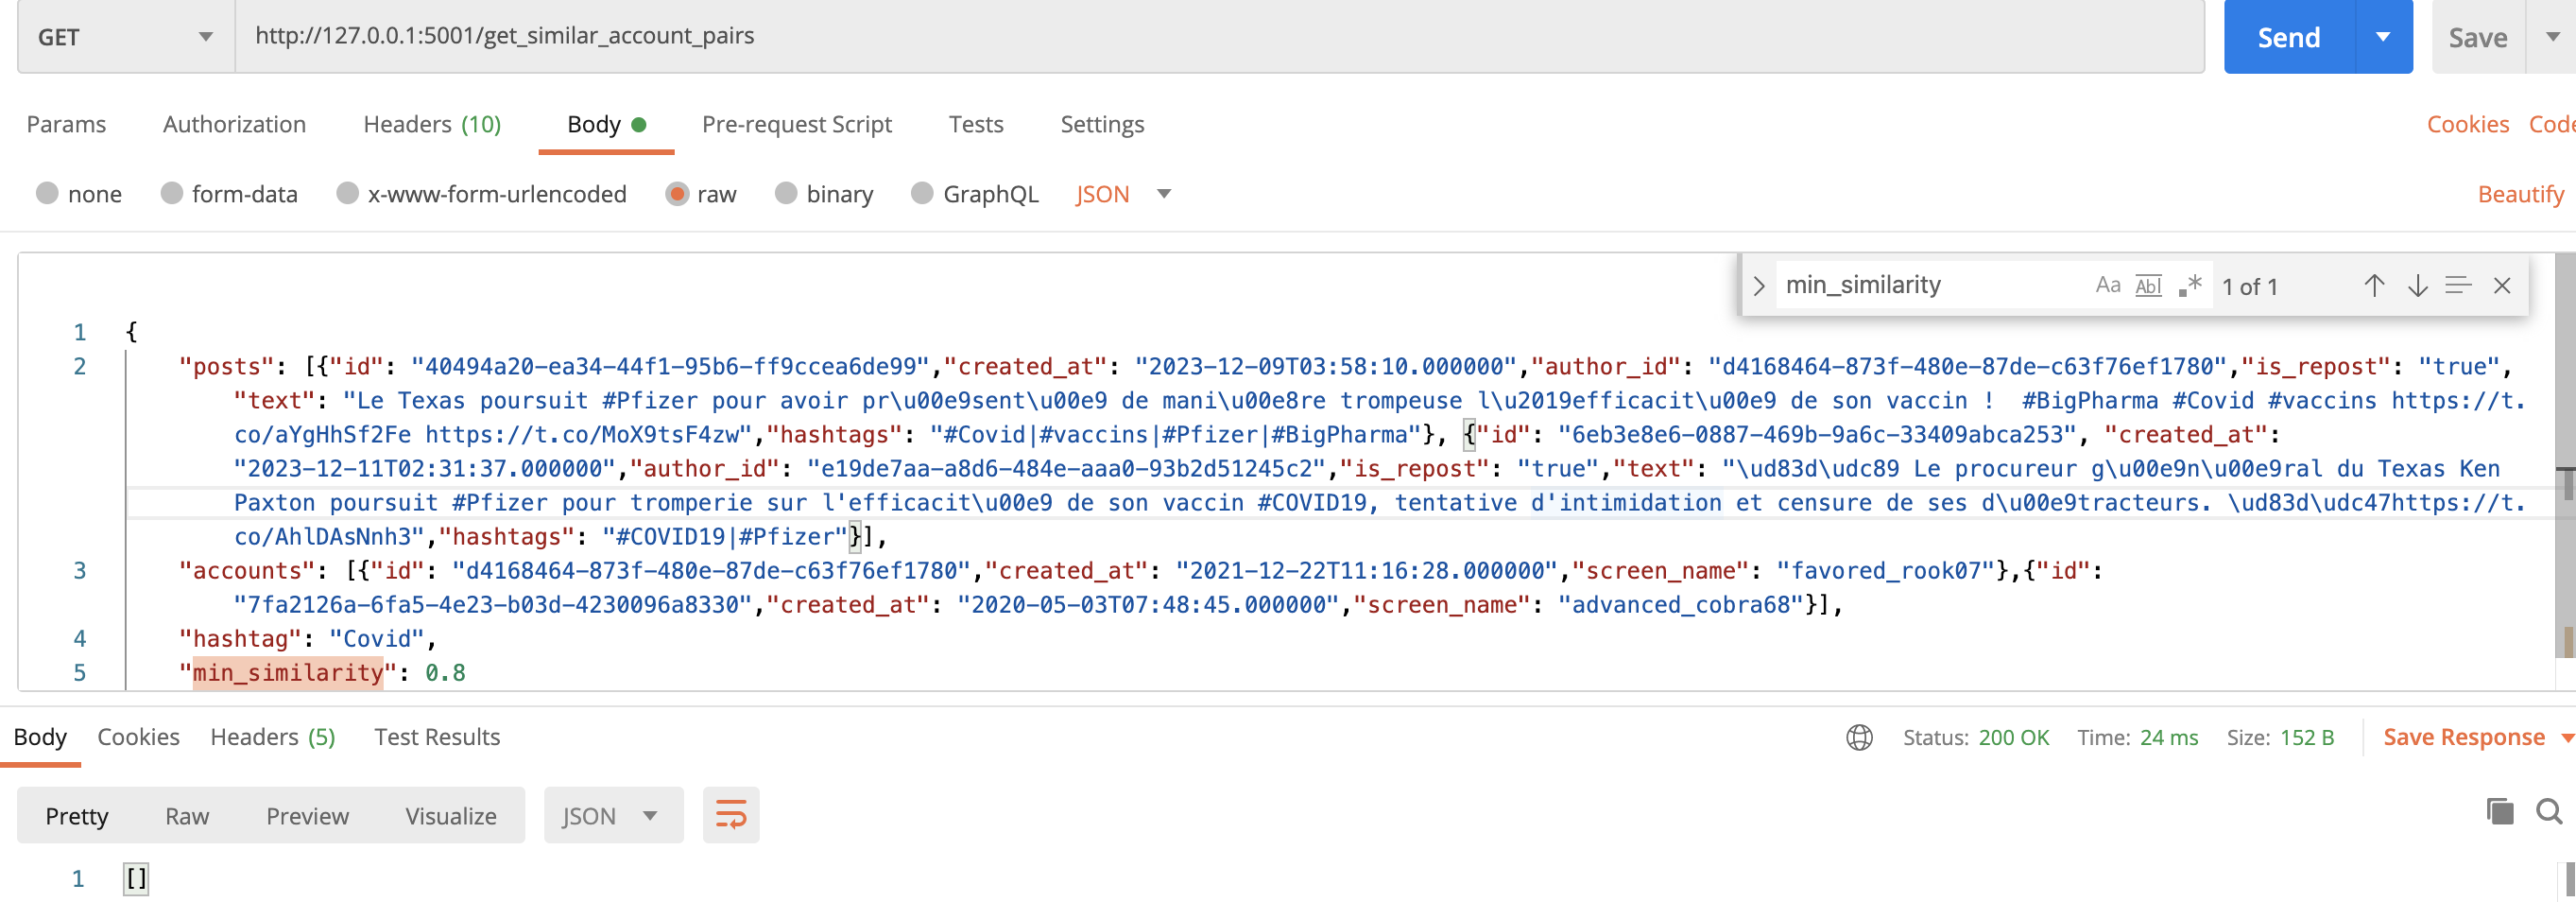

# Question 4

Given an API endpoint for our model, we want to be able to serve it in an arbitrary computing environment. Write a `requirements.txt` file and Dockerfile that could be used to containerize the model and access it via its API. You do _not_ have to build and run the container in this notebook.

requirements.txt :

pipenv \
gunicorn \
flask \
rapidfuzz \
polars \
gevent \

Dockerfile:

FROM python:3.10-slim \
WORKDIR /app \
COPY . /app \
RUN pip install -r requirements.txt \
EXPOSE 5001 \
ENV FLASK_APP=app.py \
CMD gunicorn --bind 0.0.0.0:5001 --timeout 100 -k gevent -w 1 --threads 1 app:app

# Question 5

Suppose that we have found our model performs well in practice, and we now want to deploy it to Artemis, our SaaS offering for detecting, assessing, and mitigating disinformation and other online harms. In production, there is a significantly higher volume of data, both in terms of the number of posts and accounts, and the number of users who are making concurrent requests to the model.

How would you ensure and evaluate that the model is performant in these circumstances? What monitoring may you want to put in place?

### Answer

As soon as I deploy the model in QA/Staging environment. I would first consider creating some monitoring metrics and have them in place to understand better about the API and its limitations if any:

1. Response Time Monitoring: Firstly, Measure the response time of the API endpoint with different loads. Monitor the average response time, as well as the distribution of response times. identify any cases where there is a sudden increase in response time, which can indicate performance issues.

2. Throughput Monitoring: I will identify the number of requests served per unit of time. This helps me in assessing the capacity of API endpoint and whether it can handle the expected workload.

3. Error Rate Monitoring: Monitor the rate of errors returned by API endpoint. High error rates may indicate issues with the model inference, data processing, or infrastructure.

4. Concurrency Monitoring: Identify the number of concurrent requests being processed by the endpoint. If the system is not able to process then we may consider horizontal scaling. We can consider deploying the endpoint in Kuberentes cluster that scales automatically

Finally, I wll consider having tools like Grafana/Kibana in place to collect and visualize perfomance metrics. And have a alerting mechanism if there are any issues like 1. 500 Errors 2. Out of SLA etc.

